In [75]:
import pandas as pd
%pylab inline
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
%matplotlib inline
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [2]:
bank= pd.read_csv('bank1.csv',sep=',')
bank.shape

(4521, 17)

In [3]:
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


   # DESCRIPTION
   
   2-"blue-collar","self-employed","retired","technician","services")<br> 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)<br>
   4 - education (categorical: "unknown","secondary","primary","tertiary")<br>
   5 - default: has credit in default? (binary: "yes","no")<br>
   6 - balance: average yearly balance, in euros (numeric) <br>
   7 - housing: has housing loan? (binary: "yes","no")<br>
   8 - loan: has personal loan? (binary: "yes","no")<br>
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")<br> 
  10 - day: last contact day of the month (numeric)<br>
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")<br>
  12 - duration: last contact duration, in seconds (numeric)<br>
   # other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)<br>
  15 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")<br>

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

8. Missing Attribute Values: None

In [4]:
def col_visualizer(x):
    """This function takes a variable a return 2 viz plots
    first kde distribution plot and second a histogram"""
    
    plt.figure(figsize=(9,4))
    plt.subplot(1,3,1)
    plt.hist(x, data=bank,alpha=0.8, edgecolor='black')
    
    plt.subplot(1,3,2)
    sns.distplot(bank[x])
    plt.tight_layout()
    
    plt.subplot(1,3,3)
    plt.boxplot(x, data=bank)
    

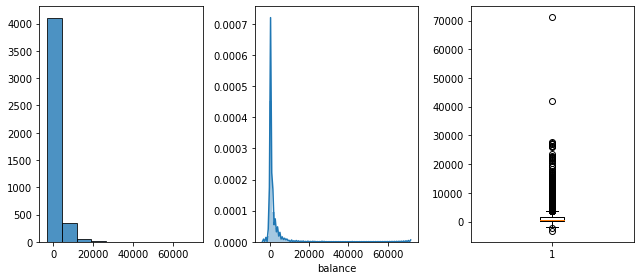

In [5]:
col_visualizer('balance')

I am a bit intrigued right skewed distribution of the age variable. We will see what we can do with that.

In [6]:
# checking the missing values
bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
for col in bank:
    if bank[col].dtypes=='object':
        print(col,'has',len(bank[col].unique()),': unique in there:\n')
        print (bank[col].value_counts())
        print('')

job has 12 : unique in there:

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

marital has 3 : unique in there:

married     2797
single      1196
divorced     528
Name: marital, dtype: int64

education has 4 : unique in there:

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

default has 2 : unique in there:

no     4445
yes      76
Name: default, dtype: int64

housing has 2 : unique in there:

yes    2559
no     1962
Name: housing, dtype: int64

loan has 2 : unique in there:

no     3830
yes     691
Name: loan, dtype: int64

contact has 3 : unique in there:

cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64

month has 12 : unique in there:

may    1398
jul     706
aug     63

Here we have a big problem, the target variable is greatly disproportionated. Any model created here that would have **y** as a target would be a **bias** model.

In [8]:
bank.groupby(['y', 'contact'])['contact'].count()

y    contact  
no   cellular     2480
     telephone     257
     unknown      1263
yes  cellular      416
     telephone      44
     unknown        61
Name: contact, dtype: int64

lets see if there is a relation between contact and the fact that people suscribe to the deposit policy as I am intrigued by this variable. The reason why I am doing this in here. It is just because I believe that we do not have enough observations for all these features. With feature engineering coming after I might a problem. I am trying to eliminate fetaures here; there are 

In [9]:
def contingency_test(cont):
    stand_val=0.05
    """Takes a Contingency table"""
    chi, p, expected,dof= chi2_contingency(cont)
    print('chi2 stats:',chi)
    print ('')
    print('P-value:',p)
    print ('')
    print('Expected:',expected)
    if p< stand_val:
        print('\nTHE VARIABLES ARE NOT INDEPENDENT')
    else:
        print ('There is nothing here')
    

In [10]:
cont=pd.crosstab(bank['y'],bank['contact'],)

In [11]:
contingency_test(cont)

chi2 stats: 87.86985650165812

P-value: 8.30430129641147e-20

Expected: 2

THE VARIABLES ARE NOT INDEPENDENT


In [12]:
X,y=bank.drop('y',1),bank['y']

In [13]:
plt.style.use('bmh')

In [14]:
def histo_viz(X):
    """This function takes a discrete variable"""
    if X.dtypes=='object':
        print ('variable must be discrete ...')
    else:
        plt.figure(figsize=(9,6))
        plt.hist(X[y=='no'], alpha=0.5, color='blue',edgecolor='k', label='No')
        plt.hist(X[y=='yes'], alpha=0.5, color='green',edgecolor='k',label='Yes')
        plt.title('{variable} by target Y Distribution'.format(variable=X.name))
        plt.xlabel('Frequency')
        plt.legend(loc=0)

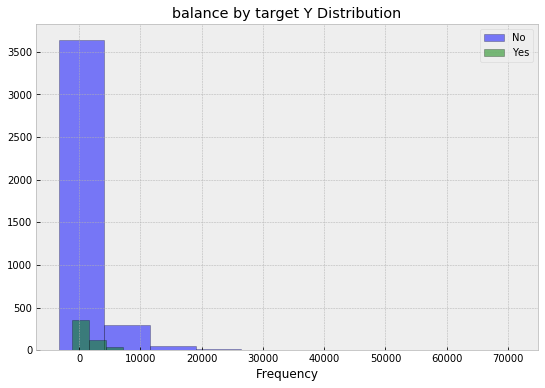

In [15]:
histo_viz(bank['balance'])

In [16]:
bank.groupby(['contact','y' ])['contact'].count()

contact    y  
cellular   no     2480
           yes     416
telephone  no      257
           yes      44
unknown    no     1263
           yes      61
Name: contact, dtype: int64

In [17]:
def catplot_viz(var):
    
    pd.crosstab(var, bank['y']).plot(kind='bar', figsize=(11,6));

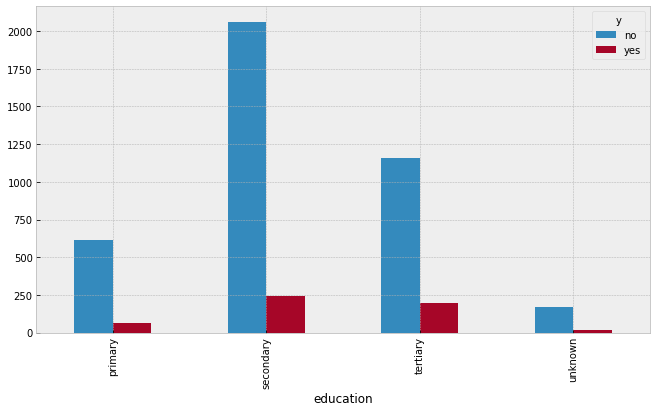

In [18]:
catplot_viz(bank['education'])

I will drop the **day**  and possibily the **month** column as this is not a data analysis exercise althout few analysis plots will be produced and time series will not used in there.

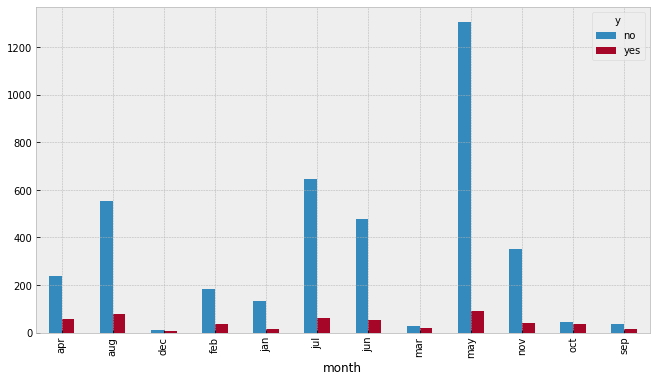

In [19]:
catplot_viz(bank['month'])

In [20]:
bank['y'].value_counts(normalize=True)

no     0.88476
yes    0.11524
Name: y, dtype: float64

Although nearly 90% of the y variable are just noes. What the data tells that december is the worst month for the deposit. That could be understandable given the nature of Decembre. However, November is not a bad month but Octobre is. Month is not likely to be a very factor (given the data **poorly distribited**)as we are already no trend towards the end of the year.<br>
Let's suppose that January is where people start suscribbing to the deposit the term, which is an average month according to the data. Feb looks better than Jan, however is very poor. let's test the hypothesis that those 2 variables are **independent**(there is relation (Null Hypothesis))

In [21]:
bank.drop('day',axis=1, inplace=True)

In [22]:
#Now drop test the month
cont1=pd.crosstab(bank['y'], bank['month'])
contingency_test(cont1)

chi2 stats: 250.50006340911358

P-value: 2.195354833570811e-47

Expected: 11

THE VARIABLES ARE NOT INDEPENDENT


Contrarily to what the data show with very significant p_value. The 2 variables (**y** & **month** )are not independent. 

In [23]:
# let's explore the pdays variable

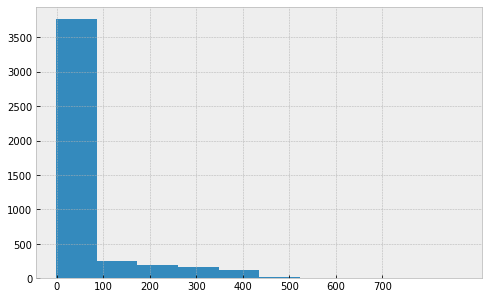

In [24]:
plt.figure(figsize=(8,5))
plt.hist(bank['pdays']);
plt.xticks(range(0,800,100));

In [25]:
bank.groupby('pdays')['pdays'].count().sort_values(ascending=False)[:5]

pdays
-1      3705
 182      23
 183      20
 363      12
 92       12
Name: pdays, dtype: int64

Considering the nature of the dataset and the variable it is d1fficult to take the -1 value as a continuous value in the dataset. It is probably representing something. I will there transform due to the quantitity of it this variable to have a good model

In [26]:
bank['pdays']=bank['pdays']+1

In [27]:
bank.groupby('pdays')['pdays'].count().sort_values(ascending=False)[:5]

pdays
0      3705
183      23
184      20
364      12
93       12
Name: pdays, dtype: int64

In [28]:
# let's do a quick age exploration
bank['age'].describe()

count    4521.000000
mean       41.170095
std        10.576211
min        19.000000
25%        33.000000
50%        39.000000
75%        49.000000
max        87.000000
Name: age, dtype: float64

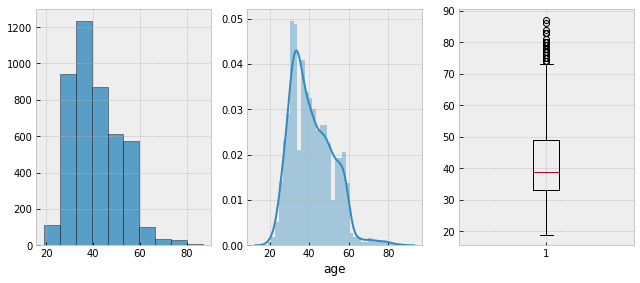

In [29]:
col_visualizer('age')

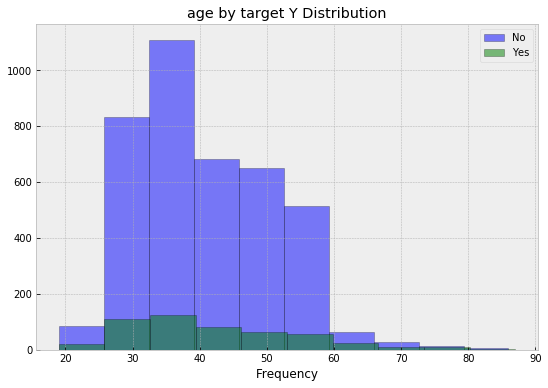

In [30]:
histo_viz(bank['age'])

In [31]:
#sns.catplot(x="education", y="balance", hue="y", kind="swarm", data=bank);

In [32]:
cate_col=[col for col in bank.columns if bank[col].dtypes=='object']
X,y= bank.drop('y', 1),bank['y']


In [33]:
# transform y
y=np.where(bank['y']=='yes', 1, 0)

In [80]:
# change change column 
trans_cols= make_column_transformer((OneHotEncoder(),['job', 'marital', 'education', 'default','housing','loan',
                                                      'contact','month','poutcome']),remainder=StandardScaler())

                            
trans_cols.fit_transform(X)


array([[ 0.        ,  0.        ,  0.        , ..., -0.57682947,
        -0.4072183 , -0.32041282],
       [ 0.        ,  0.        ,  0.        , ..., -0.57682947,
         2.98904408,  2.04173372],
       [ 0.        ,  0.        ,  0.        , ..., -0.57682947,
         2.89914302,  0.27012381],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  2.63916021,
        -0.4072183 , -0.32041282],
       [ 0.        ,  1.        ,  0.        , ...,  0.38796743,
         1.71045119,  1.45119709],
       [ 0.        ,  0.        ,  1.        , ..., -0.2552305 ,
         2.09003345,  3.81334363]])

In [81]:
# Use the class weight to balance the classes as they are unbalnced

logreg=LogisticRegression(class_weight='balanced')

In [83]:
# Making the pipeline
pipe=make_pipeline(trans_cols,logreg)
cross_val_score(pipe, X, y, cv=5,scoring='accuracy').mean()

/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/JB/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

0.8374292279861144

Remember this has not been not been standardised yet. I just want to show the importance of standardising the data at this point. There are few things that I am looking to change. Keep,on checking some update are coming soon. Tutorial on Imblearn (library dealing imbalance target) would be also included hopefully. :) . Do not hesitate to contact me by  whether you have some questions.